## Seuence alignment
This notebook will focus on sequence alignment and distances at sequence level.

In [1]:
import pandas

from helper import parse_fix_matrix, view_alignment
from Bio import AlignIO, SeqIO

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN
import numpy as np

import pickle

import pandas as pd

In [2]:
import panel as pn

from IPython.display import HTML
import panel as pn
import panel.widgets as pnw
pn.extension()

from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, Plot, LinearAxis, Grid, Range1d
from bokeh.models.glyphs import Text, Rect
from bokeh.layouts import gridplot, column



aln = AlignIO.read('data/alignment_sequence/Tom_sequences_split_23_08_03.ali','fasta')
p = view_alignment(aln, plot_width=10000)
pn.pane.Bokeh(p)
#pn.show(p)

Bokeh(GridPlot)

## Global sequence alignments

Alignments are made using clustalo. Distance calculations are made with respect to pairwise identity and with Kimura correction.

In [20]:

! clustalo --in data/raw/Tom_sequences_split_23_08_03.fasta -o data/alignment_sequence/Tom_sequences_split_23_08_03.ali  --distmat-out data/distance_sequence/identity/Tom_sequences_split_23_08_03_identity.dist --full  --threads 5 --force
! clustalo --in data/raw/Tom_sequences_split_23_08_03.fasta -o data/alignment_sequence/Tom_sequences_split_23_08_03.ali  --distmat-out data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist --full --use-kimura  --threads 5 --force

## Plot aligned identity distance 

In [7]:
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

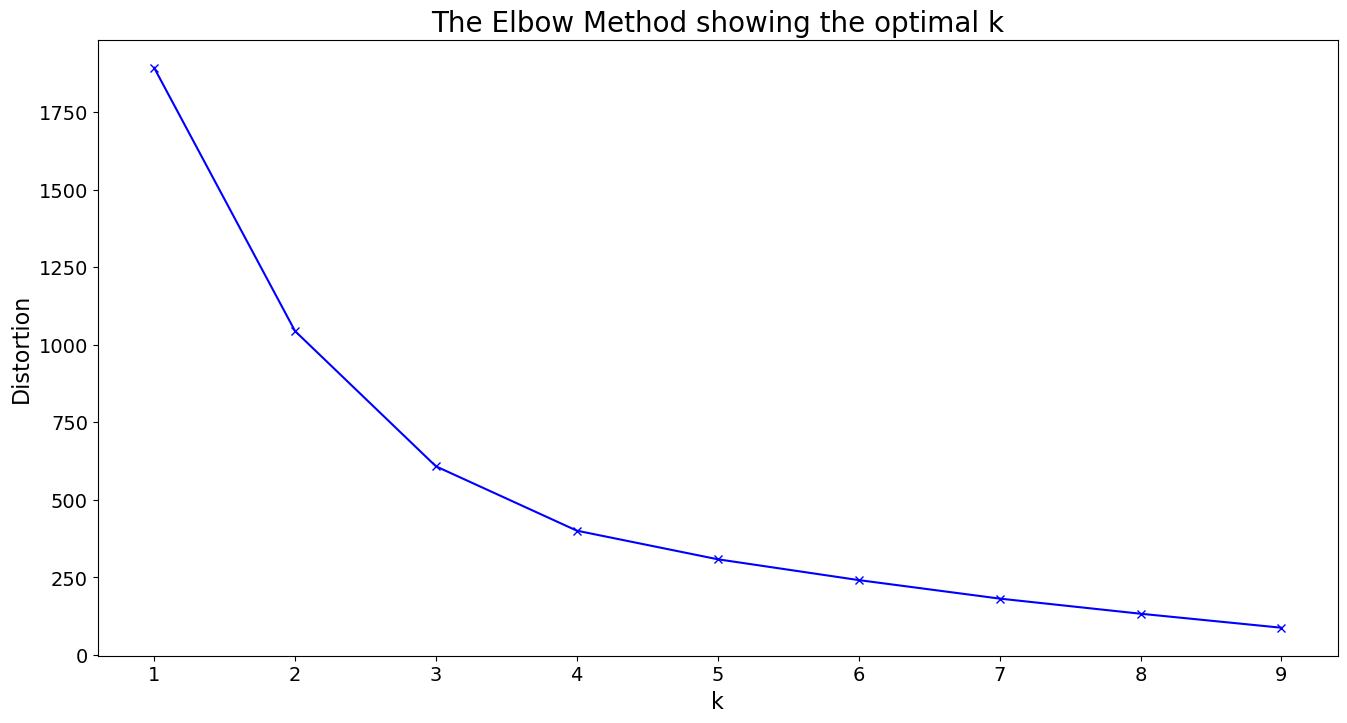

In [5]:

dict_dist, np_dist = parse_fix_matrix("data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist")
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(np_dist)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

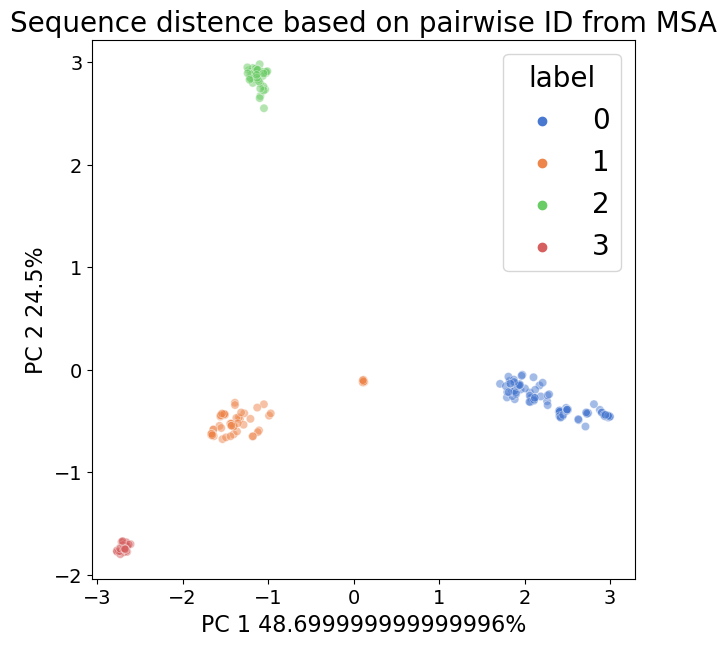

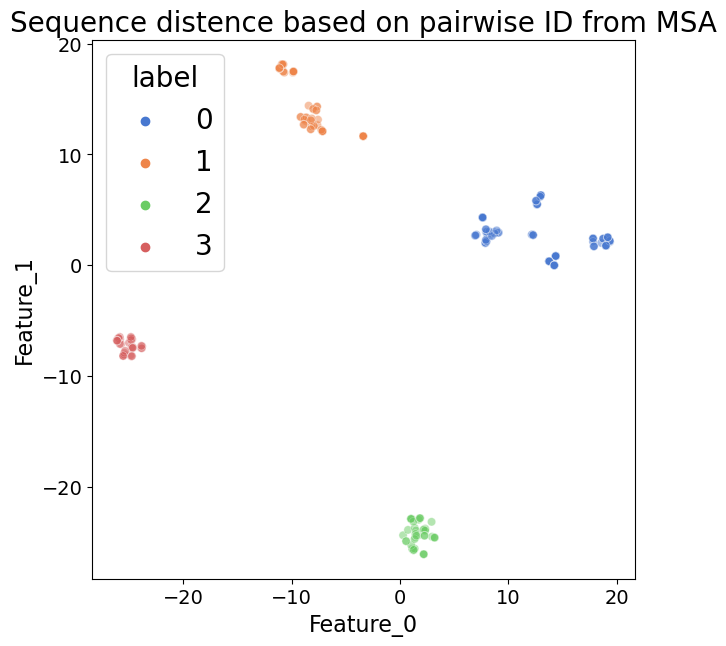

In [6]:
## Identity

dict_dist, np_dist = parse_fix_matrix("data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist")

kmeans = KMeans(n_clusters=4, random_state=0).fit(np_dist)


## PCA

pca = PCA(n_components=2)
X_embedded_pca = pca.fit_transform(np_dist)
list_explaned_varience = [ round(i, 3) for i in  pca.fit(np_dist).explained_variance_ratio_]


data_pca = {f"PC 1 {list_explaned_varience[0]*100}%":[], f"PC 2 {list_explaned_varience[1]*100}%":[]}
for x in X_embedded_pca:
    data_pca[f"PC 1 {list_explaned_varience[0]*100}%"].append(x[0])
    data_pca[f"PC 2 {list_explaned_varience[1]*100}%"].append(x[1])

    
data_pca["label"]=kmeans.labels_
data_pca["ID"] = dict_dist["id"]
f, ax = plt.subplots(figsize=[7,7])

#sns.set_theme(style="white")

# Load the example mpg dataset

sns.scatterplot(data=data_pca, x=f"PC 1 {list_explaned_varience[0]*100}%", y=f"PC 2 {list_explaned_varience[1]*100}%", #hue="origin", size="weight",
            alpha=.5, palette="muted", ax=ax, hue="label")
ax.set_title("Sequence distence based on pairwise ID from MSA")
plt.savefig("seq_dist_id.png")
plt.show()



## T-SNE



X_embedded_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30).fit_transform(np_dist)

# make_dict

data_t_sne = {"Feature_0":[], "Feature_1":[]}
for x in X_embedded_tsne:
    data_t_sne["Feature_0"].append(x[0])
    data_t_sne["Feature_1"].append(x[1])

data_t_sne["label"]=kmeans.labels_
f, ax = plt.subplots(figsize=[7,7])

#sns.set_theme(style="white")

# Load the example mpg dataset

sns.scatterplot(data=data_t_sne, x="Feature_0", y="Feature_1", #hue="origin", size="weight",
            alpha=.5, palette="muted", ax=ax, hue="label")
ax.set_title("Sequence distence based on pairwise ID from MSA")
plt.show()

## U-MAP

with open("seq_dist_Global_23_08_03.pkl", "wb") as file_writer: 
    pickle.dump(dict_dist, file_writer)

/home/sandra/anaconda3/envs/CbTan/lib/python3.11/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


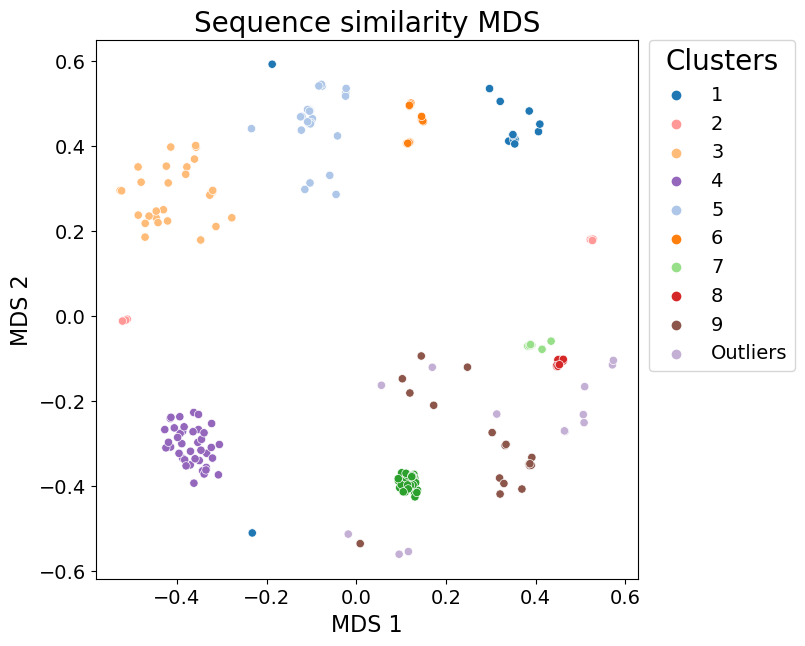

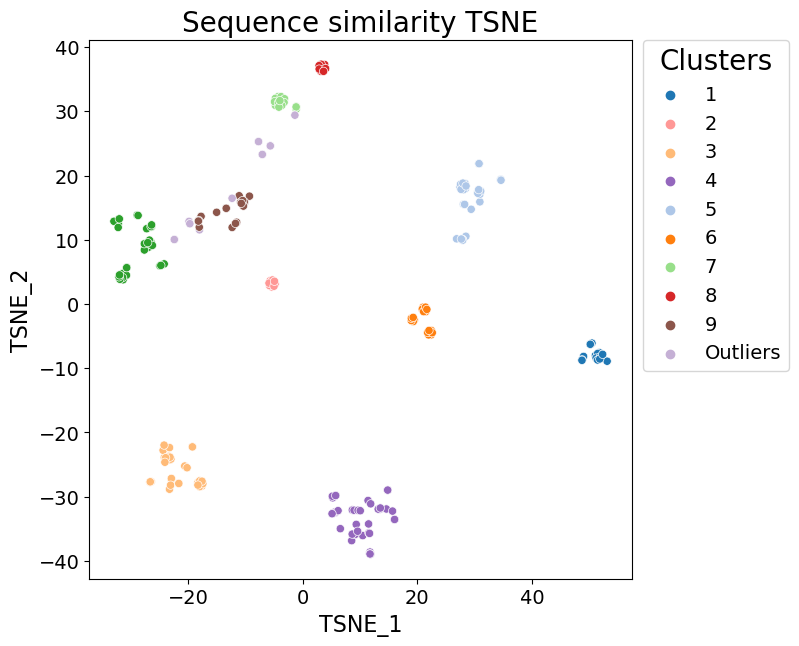

In [33]:
## Identity

dict_dist, np_dist = parse_fix_matrix("data/distance_sequence/kimura/Tom_sequences_split_23_08_03_kimura.dist")

#kmeans = DBSCAN(eps=0.5, min_samples=5, metric = "precomputed").fit(np_dist.astype(float))

kmeans = HDBSCAN(min_cluster_size = 8, min_samples=3, metric = "precomputed").fit(np_dist.astype(float))

def convert(vec):
    return vec.astype(float)

with open("seq_dist_Global_23_08_03.pkl", "rb") as file_writer: 
    seq_dict = pickle.load(file_writer)
kmeans = HDBSCAN(min_cluster_size = 8, min_samples=3, metric = "precomputed").fit(list(map(convert, seq_dict["vec"])))
## PCA

pca = MDS(n_components=2, metric=True, dissimilarity = "precomputed")
X_embedded_pca = pca.fit_transform(np_dist.astype(float))



data_pca = {f"MDS 1":[], f"MDS 2":[]}
for x in X_embedded_pca:
    data_pca[f"MDS 1"].append(x[0])
    data_pca[f"MDS 2"].append(x[1])

dict_labels = {-1:"Outliers", 0:"1", 1:"2", 2:"3", 3:"4", 4:"5", 5:"6", 6:"7", 7:"8", 8:"9", 9:"10"}
data_pca["label"]=[dict_labels[i] for i in kmeans.labels_]
data_pca["ID"] = dict_dist["id"]
f, ax = plt.subplots(figsize=[7,7])

#sns.set_theme(style="white")

# Load the example mpg dataset

sns.scatterplot(data=data_pca, x=f"MDS 1", y=f"MDS 2", #hue="origin", size="weight",
            alpha=1, palette="tab20", ax=ax, hue="label")
ax.set_title("Sequence similarity MDS")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 7, 3, 8, 1, 2, 5, 6, 10, 9]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("results/img/seq_dist_MDS.png" , bbox_inches="tight")
plt.show()



## T-SNE



X_embedded_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=10, metric="precomputed").fit_transform(np_dist.astype(float))

# make_dict

data_t_sne = {"TSNE_1":[], "TSNE_2":[]}
for x in X_embedded_tsne:
    data_t_sne["TSNE_1"].append(x[0])
    data_t_sne["TSNE_2"].append(x[1])

data_t_sne["label"]=[dict_labels[i] for i in kmeans.labels_]
f, ax = plt.subplots(figsize=[7,7])

#sns.set_theme(style="white")

# Load the example mpg dataset

sns.scatterplot(data=data_t_sne, x="TSNE_1", y="TSNE_2", #hue="origin", size="weight",
            alpha=1, palette="tab20", ax=ax, hue="label")
ax.set_title("Sequence similarity TSNE")
handles, labels = plt.gca().get_legend_handles_labels()
order = [0, 7, 3, 8, 1, 2, 5, 6, 10, 9]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],title='Clusters', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("results/img/seq_dist_TSNE.png", bbox_inches="tight")
plt.show()

## U-MAP

#with open("seq_dist_Global_23_08_03.pkl", "wb") as file_writer: 
#    pickle.dump(dict_dist, file_writer)

Help on function legend in module matplotlib.pyplot:

legend(*args, **kwargs)
    Place a legend on the Axes.
    
    Call signatures::
    
        legend()
        legend(handles, labels)
        legend(handles=handles)
        legend(labels)
    
    The call signatures correspond to the following different ways to use
    this method:
    
    **1. Automatic detection of elements to be shown in the legend**
    
    The elements to be added to the legend are automatically determined,
    when you do not pass in any extra arguments.
    
    In this case, the labels are taken from the artist. You can specify
    them either at artist creation or by calling the
    :meth:`~.Artist.set_label` method on the artist::
    
        ax.plot([1, 2, 3], label='Inline label')
        ax.legend()
    
    or::
    
        line, = ax.plot([1, 2, 3])
        line.set_label('Label via method')
        ax.legend()
    
    .. note::
        Specific artists can be excluded from the automatic leg

In [87]:
stop = len("-----------------------------------------------------------------------------------------------------------------------------------CTPQ---------------------------------ART-SDNTNQPASNVDLEEFKSLKLDMTQWSYD------EDNDCYYQLGIQYCTKPASKSVNTLSVFVPGKYFSGKKNG-STYECEVSE--KAVVGSFTARTAPIVMPINTATLFPQSAPTSYA---------------------------------------------------------YEGLAPYLEAGFVYVYAGFRGRSAGYDS-----------TTGSDELYAGGSPWPAVDFKAAIRYLRYNNELLPCNTSKIFVFGFAAGGGLSAVLGTSGDSSLYMPYLKAVGAATHSE-KGEQLSDSIYGSASWCPATSYDLADAAYEWSAGQYADAT----------------------DSRAEGVWTQPLS")
start = len("-----------------------------------------------------------------------------------------------------------------------------------CTPQ---------------------------------ART-SDNTNQPASNVDLEEFKSLKLDMTQWSYD------EDNDCYYQLGIQYCTKPASKSVNTLSVFVPGKYFSGKKNG-STYECEVSE--KAVVGSFTARTAPIVMPINTATLFPQSAPTSYA---------------------------------------------------------YEGLAPYLEAGFVYVYAGFRGRSAGYDS-----------TTGSDELYAGGSPWPAVDFKAAIRYLRYNNELLPCNTSKIFVFGFAAGGGLSAVLGTSGDSSLYMPYLKAVGAATHSE-KGEQLSDSIYGSASWCPATSYDLADAA")


In [11]:
np_dist.astype(float)

array([[0.      , 0.647863, 0.62735 , ..., 0.821277, 0.817814, 0.842857],
       [0.647863, 0.      , 0.513423, ..., 0.806383, 0.809717, 0.816327],
       [0.62735 , 0.513423, 0.      , ..., 0.8     , 0.791498, 0.806122],
       ...,
       [0.821277, 0.806383, 0.8     , ..., 0.      , 0.582979, 0.531915],
       [0.817814, 0.809717, 0.791498, ..., 0.582979, 0.      , 0.565306],
       [0.842857, 0.816327, 0.806122, ..., 0.531915, 0.565306, 0.      ]])

In [89]:
#df = pd.read_csv("results/plddt/plddt_ranked_0.csv")
# Load alignment
new_df = {"ID": [], "Needle":[], "Needle_length":[], "Needle_start":[], "Needle_stop":[]} #, "Needle_plddt":[]}
for idx, rec in enumerate(SeqIO.parse("data/alignment_sequence/Tom_sequences_split_23_08_03.ali", "fasta")):
    idx_str = 0
    nidle=""
    start_stop = [0, 0]
    for idx_ali, seq in enumerate(str(rec.seq)):
        
        if seq != "-":
            idx_str += 1
            if idx_ali >= start and idx_ali <= stop:
                nidle = nidle + seq
        if idx_ali == start:
                start_stop[0] = idx_str
        if idx_ali == stop:
                start_stop[1] = idx_str
        else:
            pass
    # Make temp dp
    #if rec.id in ["2641118398", "2826355069", "2854057680"]:
    #    continue
    #print(rec.id)
    if rec.id in ["4j0h_A", "7q6y_A", "6yq4_A"]:
        new_df["ID"].append(rec.id)
        new_df["Needle"].append(nidle)
        new_df["Needle_length"].append(start_stop[1]-start_stop[0])
        new_df["Needle_start"].append(start_stop[0])
        new_df["Needle_stop"].append(start_stop[1])
      #  new_df["Needle_plddt"].append(1.0)
    else:    
        #list_idx = df.loc[df["ID"]==f"{rec.id}.pdb"]["aa_pos"].values[0].split(";")
        #list_plddt = df.loc[df["ID"]==f"{rec.id}.pdb"]["plddt"].values[0].split(";")

       # tmp_df = pd.DataFrame({"plddt":list_plddt, "aa_pos": list_idx})
       # tmp_df = tmp_df.drop_duplicates(subset=['aa_pos'])
      #  tmp_df["aa_pos"] = pd.to_numeric(tmp_df["aa_pos"]) 
       # tmp_df["plddt"] = pd.to_numeric(tmp_df["plddt"]) 
        # calc nidle plddt
       # tmp_df = tmp_df.loc[tmp_df["aa_pos"]>start_stop[0]]
       # tmp_df = tmp_df.loc[tmp_df["aa_pos"]<start_stop[1]]

        new_df["ID"].append(rec.id)
        new_df["Needle"].append(nidle)
        new_df["Needle_length"].append(start_stop[1]-start_stop[0])
        new_df["Needle_start"].append(start_stop[0])
        new_df["Needle_stop"].append(start_stop[1])
        #new_df["Needle_plddt"].append(tmp_df['plddt'].mean())
    
    #print(f"Mean plddt: {df[df['ID'] == f'{rec.id}.pdb']['plddt_avg'].values}")
    #print(f"Mean plddt nidle: {tmp_df['plddt'].mean()}")
    #print(f"ID: {rec.id}")
    #print(f"Nidle domain starts: {start_stop[0]} stops: {start_stop[1]} is: {nidle}")
new_df = pd.DataFrame(new_df)

In [90]:
new_df

ID                                            Needle  \
0        TanAAp                        YEWSAGQYADATDSRAEGVWTQPLSQ   
1        TanALp                         YEWNMGQYSNSGTRKQGTWTKALSN   
2        TanASl                         YEWQMGQYGNEGNRKKNSFQKQLST   
3        TanASg                             YEWNMGSTRSDLSDEEQTISD   
4       TanBFnp  YEWMYNGVNSYSRMEFTRNTSAQEYNDRSLTRSTVQGNLTEDEIKISN   
..          ...                                               ...   
225  2925436013      YEWQFNGINDWHRYQPVAGTTKNGRPKFEPVSGQLTVEEQALSL   
226  2925440967      YEWQFDGINDWNRSQPVAGSMKNGRPKFEPITGTLSASDQSLSA   
227      4j0h_A      YEWQFNGINDWHRYQPVAGTTKNGRPKFEPVSGQLTVEEQALSL   
228      6yq4_A  YEWMYNGVNSYSRMEFTRNTSAQEYNDRSLTRSTVQGNLTNDEINISN   
229      7q6y_A         YEWQFCGYNDYHRIKHVRSESGVKNIQIDGILTEKQIKISE   

     Needle_length  Needle_start  Needle_stop  
0               25           252          277  
1               24           255          279  
2               24           264          288  
3               20           240          260  
4               47           225          272  
..             ...           ...          ...  
225             43           216          259  
226             43           216          259  
227             43           217          260  
228             47           219          266  
229             40           228          268  

[230 rows x 5 columns]

In [91]:
new_df.to_csv("Needle_23_08_03.csv")

with open("results/sub_sequence/Needle_23_08_03.fasta", 'w') as f:
    for row in new_df.iterrows():
        f.write(f">{row[1]['ID']}\n{row[1]['Needle']}\n")

In [92]:
! clustalo --in results/sub_sequence/Needle_23_08_03.fasta -o results/sub_sequence_ali/Needle_23_08_03.ali  --distmat-out results/sub_sequence_dist/Needle_identity_23_08_03.dist --full  --threads 5 --force
! clustalo --in results/sub_sequence/Needle_23_08_03.fasta -o results/sub_sequence_ali/Needle_23_08_03.ali  --distmat-out results/sub_sequence_dist/Needle_kimura_23_08_03.dist --full --use-kimura  --threads 5 --force

In [93]:
aln = AlignIO.read('results/sub_sequence_ali/Needle_23_08_03.ali','fasta')
p = view_alignment(aln, plot_width=1000)
pn.pane.Bokeh(p)

Bokeh(Column)

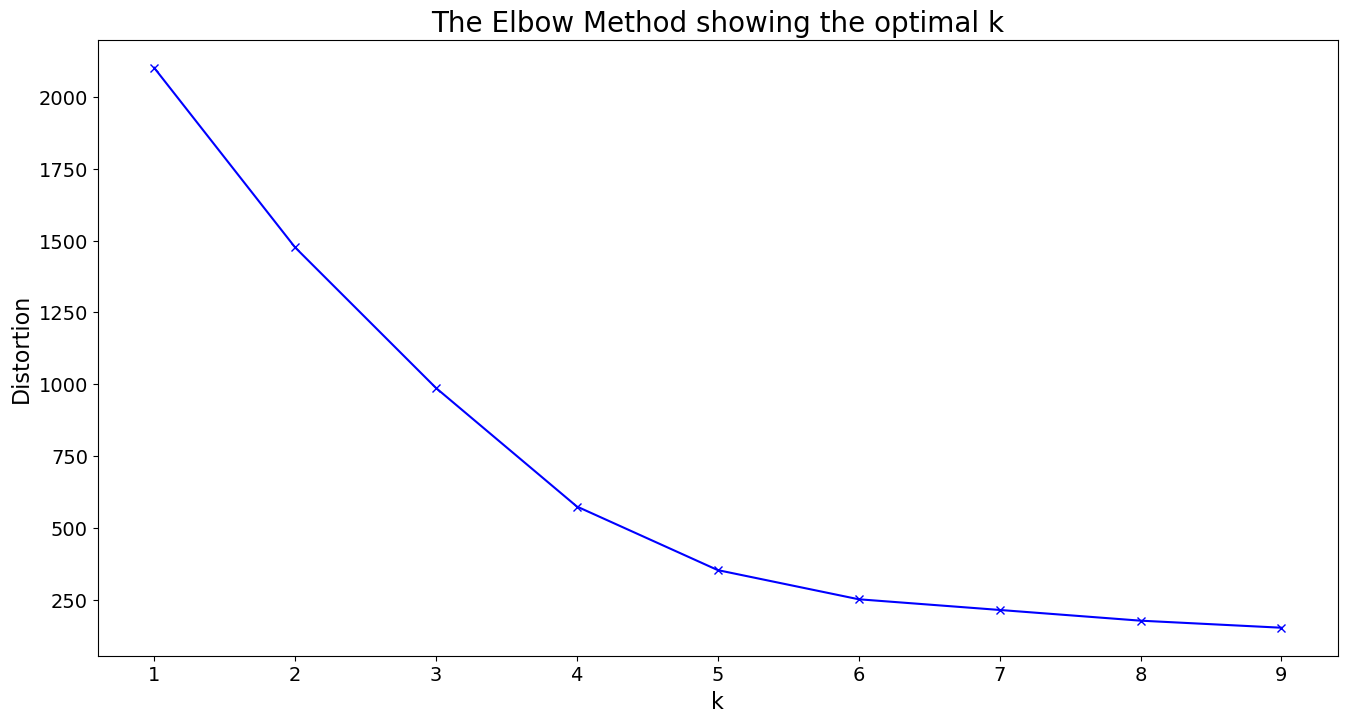

In [94]:
dict_dist, np_dist = parse_fix_matrix("results/sub_sequence_dist/Needle_kimura_23_08_03.dist")
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(np_dist)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

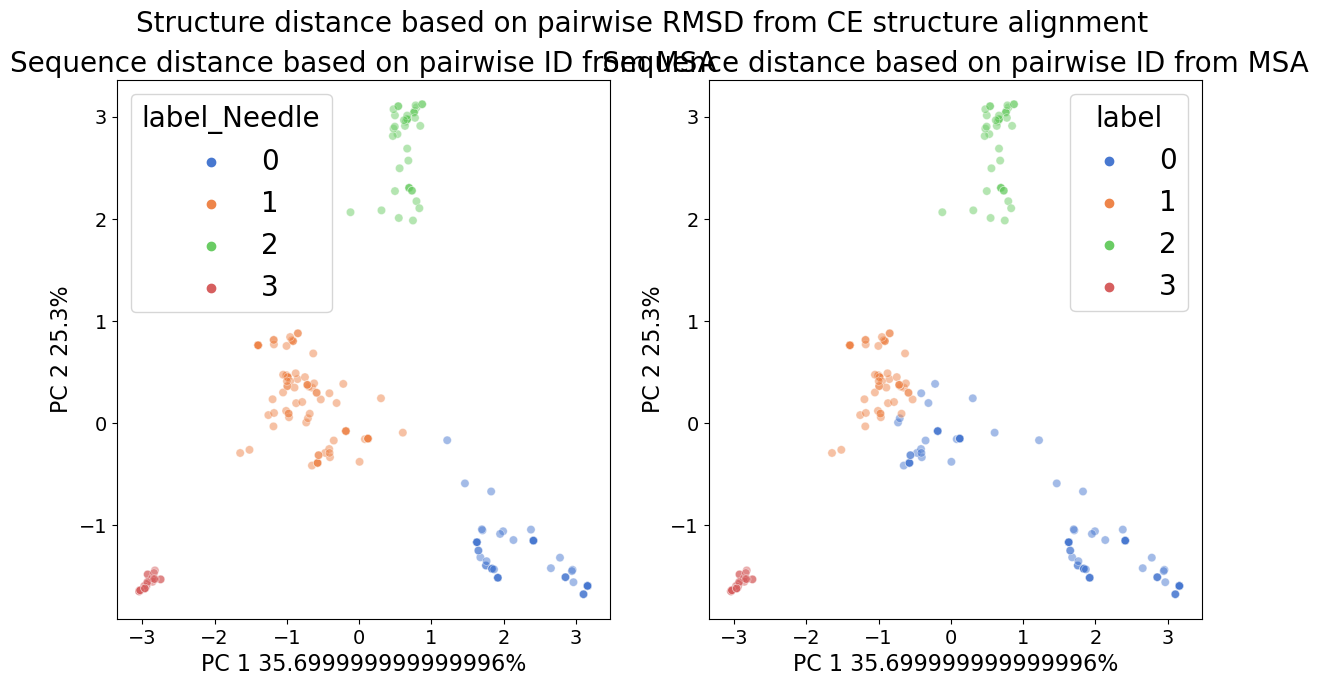

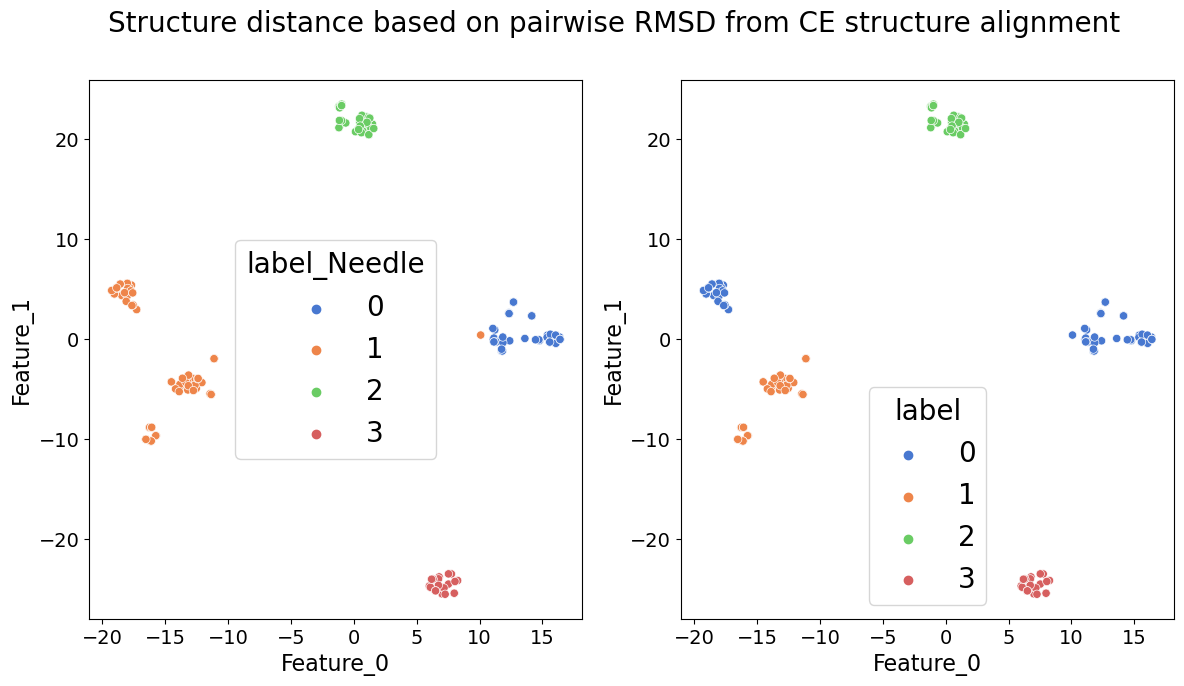

In [116]:
## Identity


## Extract lables from global alignment clustering
data_pca = pd.DataFrame(data_pca)
#a = [ "2641118398", "2826355069", "2854057680"]
df_temp = data_pca #[~data_pca['ID'].isin(a)]
lable_global_align = df_temp["label"].values

dict_dist, np_dist = parse_fix_matrix("results/sub_sequence_dist/Needle_kimura_23_08_03.dist")

kmeans_Needle = KMeans(n_clusters=4, random_state=15).fit(np_dist)


## PCA

pca = PCA(n_components=2)
X_embedded_pca = pca.fit_transform(np_dist)
list_explaned_varience = [ round(i, 3) for i in  pca.fit(np_dist).explained_variance_ratio_]


data_pca_Needle = {f"PC 1 {list_explaned_varience[0]*100}%":[], f"PC 2 {list_explaned_varience[1]*100}%":[]}
for x in X_embedded_pca:
    data_pca_Needle[f"PC 1 {list_explaned_varience[0]*100}%"].append(x[0])
    data_pca_Needle[f"PC 2 {list_explaned_varience[1]*100}%"].append(x[1])

data_pca_Needle = pd.DataFrame(data_pca_Needle)    
data_pca_Needle["label_Needle"]=kmeans_Needle.labels_
data_pca_Needle["label"]=lable_global_align
data_pca_Needle["ID"]=dict_dist["id"]
f, ax = plt.subplots(1,2,figsize=[14,7])
#sns.set_theme(style="white")

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")
sns.scatterplot(data=data_pca_Needle, x=f"PC 1 {list_explaned_varience[0]*100}%", y=f"PC 2 {list_explaned_varience[1]*100}%", #hue="origin", size="weight",
            alpha=.5, palette="muted", ax=ax[0], hue="label_Needle")
ax[0].set_title("Sequence distance based on pairwise ID from MSA")


sns.scatterplot(data=data_pca_Needle, x=f"PC 1 {list_explaned_varience[0]*100}%", y=f"PC 2 {list_explaned_varience[1]*100}%", #hue="origin", size="weight",
            alpha=.5, palette="muted", ax=ax[1], hue="label")
ax[1].set_title("Sequence distance based on pairwise ID from MSA")

f.suptitle("Structure distance based on pairwise RMSD from CE structure alignment")
f.savefig("struct_dist_rmsd.png")
plt.show()



## T-SNE



X_embedded_tsne = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=30).fit_transform(np_dist)

# make_dict

data_t_sne = {"Feature_0":[], "Feature_1":[]}
for x in X_embedded_tsne:
    data_t_sne["Feature_0"].append(x[0])
    data_t_sne["Feature_1"].append(x[1])

data_t_sne["label_Needle"]=kmeans_Needle.labels_
data_t_sne["label"]=lable_global_align

f, ax = plt.subplots(1,2,figsize=[14,7])

#sns.set_theme(style="white")

# Load the example mpg dataset
mpg = sns.load_dataset("mpg")
sns.scatterplot(data=data_t_sne, x="Feature_0", y="Feature_1", #hue="origin", size="weight",
            alpha=1, palette="muted", ax=ax[0], hue="label_Needle")
sns.scatterplot(data=data_t_sne, x="Feature_0", y="Feature_1", #hue="origin", size="weight",
            alpha=1, palette="muted", ax=ax[1], hue="label")

f.suptitle("Structure distance based on pairwise RMSD from CE structure alignment")
f.savefig("struct_dist_rmsd.png")
plt.show()

## U-MAP






with open("seq_dist_Needle_23_08_03.pkl", "wb") as file_writer: 
    pickle.dump(dict_dist, file_writer)

In [ ]:
#TanCb1 s216 h611 q577 
S216 H611 Q577
CbTan2: S175 H471 D439
        S436 H933 D896 # Alignment
Make structure comp of catalytic triad.

In [34]:
TanCb1 = "CGNTSKSISDSKDNKSSYSSTYNQNNEALKFDTAKWNYDETNNVYWTIGVQYCSDPESTDYETMAIYVPGEYMTGTKNSDGTYTCEINKSGEVNGYTSETAPIILPIDTPGYSAQAAPTSYNYDSAASYLKAGYVYVVAGMRGRSSLQGTSEDQGFSGGAPWGVTDLKAAVRYYRFNESLLPGDTDRFFSYGMSGGGAQSALMGATGDSELYYPYLESIGSAMTDADGNVISDAIAGSMDWCPVTSLDYANEAYEWNMGQYFTTDTRDSSSFKSALSKDMAASFAEYVNKLGLKSEDGTELTLSESEAGVYNNGTYYDYILNEIQTSLNNFLSDTTFPYTYTQGKIQIGNTASSGGGEGIDLSRNPGQGVNKDGQMPPQGQNGGRGQGAGMMQGGAQLSESKTYETAQDYIDSLNSDGTWIAYDSQTNTGKITSIEDFVKHCKEATKPVGAFDSVDLSRGENNLFGNGQSTALHFDSVESSLLSKNESNYSQYSDWDSSYITSFEDDLKSEDSIGTDMQTRVNMYNPMYYLSSYYSGYNTSKVAKYWRIRTGINQTDTALTVETNLKLALQNYDGVESVDFATVWGQPHTTAERTGNSTDNFISWVDECLK"
TanCb1_ali = "-----------------------------------------------------------------------------------------------------------------------------------CGNTSK----------------------------------SISDSKDNKSSYSSTYNQNNEALKFDTAKWNYD------ETNNVYWTIGVQYCSDPESTDYETMAIYVPGEYMTGTKNSDGTYTCEINK--SGEVNGYTSETAPIILPIDTPGYSAQAAPTSYN---------------------------------------------------------YDSAASYLKAGYVYVVAGMRGRSSLQGT-------------SEDQGFSGGAPWGVTDLKAAVRYYRFNESLLPGDTDRFFSYGMSGGGAQSALMGATGDSELYYPYLESIGSAMTDA-DGNVISDAIAGSMDWCPVTSLDYANEAYEWNMGQYFTT-----------------------DTRDSSSFKSALSKDMAASFAEYVNKLGLKSEDGTELTLSESEAGVYNNGTYYDY-ILNEIQTSLNNFLSDTTFPYTYTQGKIQI--GNTASSGGGEGIDLSRNPGQGV---NKDGQMPPQGQNG------GRGQGAGMMQG--------------------------------------------------G--AQLSESKTYETAQDYIDSLNS--DGTW-IAYDSQTNTGKITSIEDFVKHCKEATKPVGAFDSVDLSR--GENNLFGNGQS-TALHFDSVESSLLSKNESNYSQY-SDWDSSYITSFEDDLKSED----SIGTDMQTRVNMYNPMYYLSSYYSGYNTSKVAKYWRIRTGINQTDTALTVETNLKLALQNYD---GVESVDFATVWGQPHTTAERTGNSTDNFISWVDECLK------------------------"


TanCb2 = "MLIFDDKNYKVDTCNIDGISIKFRSFKEILYCEKPVDSIQKMNIFVPEVYYEGNTINGYSLHTAPIFMPNTVGGYMPGPADEPGKDFKGRINSIFRALKHGYIVVSAGVRGRTSGVKTNEFFVGSKAGEISNENGKMVGRAPALVVDMKAAIRYLRYNKGRIPGNTECIVTNGTSAGGALSAIIGASGNSEDYNPYLKEIGAADERDDIFAASCYCPIHNLENADAAYEWQFCGYNDYHRIKHVRSESGVKNIQIDGILTEKQIKISEELKRLFPKYLNSLKLKDSSNNELLLDENGEGSFKEYIKKLVINSAQKELDLCSTYKIIDNAAVCGSKIDEQEYLSIEDEKVVDINWDGFIKKITRMKVAPAFDALDLKSPENEEFGTEAIKAKHFTAYSQEHSEVEGTLADPKIIKLLNPIEYINNSDTAKYWRVRHGAFDRDISLAMPSILSLTLENNGYVVDFSLPWGIPHSGDYDLDDLFAWIDEIYTK"
TanCb2_ali = "-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------MLIFDDKNYKVDTCNID-----GISIKFRSFKEILYCEKPVDS-IQKMNIFVPEVYYEGN-----------------TINGYSLHTAPIFMPNTVGGYMPGPADEPGKDFK----------------------------------------------------GRINSIFRALKHGYIVVSAGVRGRTSGVKTNEFFVGSKAGEISNENGKMVGRAPALVVDMKAAIRYLRYNKGRIPGNTECIVTNGTSAGGALSAIIGASGNSEDYNPYLKEIGAA-D-------ERDDIFAASCYCPIHNLENADAAYEWQFCGYNDYHRIKHVRS-------ESGVKNIQIDGILTEKQIKISEELKRLFPKYLNSLKLKDSSNNELLLDENGE-----GSFKEY-IKKLVINSAQKELDLCST-----YKIIDNAAVCG----------------------------------------------------------------------------------------------------------------------SKID------EQEY-LSIE--DEKVVDINWDGFI-KKITRMKVAPAFDALDLKS--PENEEFGTEAI-KAKHFTAYSQEH---------------------------SEVE-G----TLADPKIIKLLNPIEYINN------S-DTAKYWRVRHGAFDRDISLAMPSILSLTLENNG-----YVVDFSLPWGIPHSGDYD----LDDLFAWIDEIYTK-----------------------"

print(TanCb1[215])
print(TanCb2_ali[896])





L
D


In [32]:
print(len("-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------MLIFDDKNYKVDTCNID-----GISIKFRSFKEILYCEKPVDS-IQKMNIFVPEVYYEGN-----------------TINGYSLHTAPIFMPNTVGGYMPGPADEPGKDFK----------------------------------------------------GRINSIFRALKHGYIVVSAGVRGRTSGVKTNEFFVGSKAGEISNENGKMVGRAPALVVDMKAAIRYLRYNKGRIPGNTECIVTNGTSAGGALSAIIGASGNSEDYNPYLKEIGAA-D-------ERDDIFAASCYCPIHNLENADAAYEWQFCGYNDYHRIKHVRS-------ESGVKNIQIDGILTEKQIKISEELKRLFPKYLNSLKLKDSSNNELLLDENGE-----GSFKEY-IKKLVINSAQKELDLCST-----YKIIDNAAVCG----------------------------------------------------------------------------------------------------------------------SKID------EQEY-LSIE--DEKVVDINWDGFI-KKITRMKVAPAFDALDLKS--PENEEFGTEAI-KAKHFTAYSQEH---------------------------SEVE-G----TLADPKIIKLLNPIEYINN------S-DTAKYWRVRHGAFD"))

897


In [37]:
df = pd.read_csv("results/plddt/plddt_ranked_0.csv")
# Load alignment
new_df = {"ID": [], "Active_triad":[], "S":[], "D":[], "H":[]}
for idx, rec in enumerate(SeqIO.parse("data/alignment_sequence/Tom_sequences_split_23_03_23.ali", "fasta")):
    idx_str = 0
    nidle=""
    start_stop = [0, 0, 0]
    for idx_ali, seq in enumerate(str(rec.seq)):
        
        #if seq != "-":
        idx_str += 1
        if idx_ali in [436, 896, 933]:
            nidle = nidle + seq
        if idx_ali == 437:
                start_stop[0] = idx_str
        if idx_ali == 897:
                start_stop[1] = idx_str
        if idx_ali == 934:
                start_stop[2] = idx_str
        else:
            pass

    if rec.id in ["4j0h_A", "7q6y_A", "6yq4_A"]:
        continue
        new_df["ID"].append(rec.id)
        new_df["Active_triad"].append(nidle)
        new_df["S"].append(start_stop[0])
        new_df["D"].append(start_stop[1])
        new_df["H"].append(start_stop[2])

    else:    
        list_idx = df.loc[df["ID"]==f"{rec.id}.pdb"]["aa_pos"].values[0].split(";")
        list_plddt = df.loc[df["ID"]==f"{rec.id}.pdb"]["plddt"].values[0].split(";")

        tmp_df = pd.DataFrame({"plddt":list_plddt, "aa_pos": list_idx})
        tmp_df = tmp_df.drop_duplicates(subset=['aa_pos'])
        tmp_df["aa_pos"] = pd.to_numeric(tmp_df["aa_pos"]) 
        tmp_df["plddt"] = pd.to_numeric(tmp_df["plddt"]) 
        # calc nidle plddt
        tmp_df = tmp_df.loc[tmp_df["aa_pos"]>start_stop[0]]
        tmp_df = tmp_df.loc[tmp_df["aa_pos"]<start_stop[1]]

        new_df["ID"].append(rec.id)
        new_df["Active_triad"].append(nidle)
        new_df["S"].append(start_stop[0])
        new_df["D"].append(start_stop[1])
        new_df["H"].append(start_stop[2])

    
    #print(f"Mean plddt: {df[df['ID'] == f'{rec.id}.pdb']['plddt_avg'].values}")
    #print(f"Mean plddt nidle: {tmp_df['plddt'].mean()}")
    #print(f"ID: {rec.id}")
    #print(f"Nidle domain starts: {start_stop[0]} stops: {start_stop[1]} is: {nidle}")
new_df = pd.DataFrame(new_df)

In [43]:
new_df.to_csv("active_site_selection.csv")

In [15]:
new_df.loc[new_df["ID"] == "TanCb2"]

ID Active_triad    S    D    H
11  TanCb2          SDH  438  898  935

In [38]:
def label_maker_TanCb_active(x):
    if x[0] != "S" or x[2] != "H":
        return "Not Tan"
    elif x[1] in ["D", "E"]:
        return "Acid"
    elif x[1] in ["N", "Q"]:
        return "Amide"
    else:
        return "Not Tan"

def label_maker_TanCb_active_why_not(x):

    string = "Missing: "
    if x[0] != "S":
        string = string + "".join("S, ")
    if x[2] != "H":
        string = string + "".join("H, ")
    if x[1] not in ["D", "E", "N", "Q"]:
        string = string + "".join("[D/E/N/Q]")

    if string == "Missing: ":
        return "Is Tan"
    if string[-2:] == ", ":
        return string[:-2]
    return string
        

new_df["class"] = new_df["Active_triad"].apply(lambda x: label_maker_TanCb(x))
new_df["Reason"] =  new_df["Active_triad"].apply(lambda x: label_maker_TanCb_active_why_not(x))

In [39]:
new_df.loc[new_df["class"] == "Not Tan"]

ID Active_triad    S    D    H    class                    Reason
0        TanAAp          ANH  438  898  935  Not Tan                Missing: S
68   2541814430          GSF  438  898  935  Not Tan  Missing: S, H, [D/E/N/Q]
72   2559783787          GQF  438  898  935  Not Tan             Missing: S, H
73   2561325321          ANH  438  898  935  Not Tan                Missing: S
74   2561327489          ANH  438  898  935  Not Tan                Missing: S
80   2582171838          S--  438  898  935  Not Tan     Missing: H, [D/E/N/Q]
83   2598962618          S--  438  898  935  Not Tan     Missing: H, [D/E/N/Q]
86   2601013064          ANH  438  898  935  Not Tan                Missing: S
88   2609146504          GQY  438  898  935  Not Tan             Missing: S, H
94   2636509363          S--  438  898  935  Not Tan     Missing: H, [D/E/N/Q]
105  2663663996          GQY  438  898  935  Not Tan             Missing: S, H
110  2688359802          GQF  438  898  935  Not Tan             Missing: S, H
121  2753158319          GDH  438  898  935  Not Tan                Missing: S
131  2776324838          GQF  438  898  935  Not Tan             Missing: S, H
133  2777946331          S--  438  898  935  Not Tan     Missing: H, [D/E/N/Q]
138  2789340305          GSF  438  898  935  Not Tan  Missing: S, H, [D/E/N/Q]
140  2790744589          ADH  438  898  935  Not Tan                Missing: S
141  2790746446          GDH  438  898  935  Not Tan                Missing: S
142  2790749455          GDH  438  898  935  Not Tan                Missing: S
143  2790753388          GDH  438  898  935  Not Tan                Missing: S
144  2792388898          GQF  438  898  935  Not Tan             Missing: S, H
157  2800742131          SQ-  438  898  935  Not Tan                Missing: H
158  2800827582          GQF  438  898  935  Not Tan             Missing: S, H
183  2841219448          ADH  438  898  935  Not Tan                Missing: S
186  2846504933          ADH  438  898  935  Not Tan                Missing: S
189  2865153889          GDH  438  898  935  Not Tan                Missing: S
191  2866957454          ADH  438  898  935  Not Tan                Missing: S
197  2895297582          GQF  438  898  935  Not Tan             Missing: S, H
202  2911617436          GDH  438  898  935  Not Tan                Missing: S
205  2923490717          GQF  438  898  935  Not Tan             Missing: S, H
211   650748690          -QH  438  898  935  Not Tan                Missing: S
214  2559698877          GSF  438  898  935  Not Tan  Missing: S, H, [D/E/N/Q]
218  2587225559          -QH  438  898  935  Not Tan                Missing: S
232  2701455799          S--  438  898  935  Not Tan     Missing: H, [D/E/N/Q]

In [40]:
new_df.to_csv("active_site_class.csv")

In [32]:
string

'Missing: ,'